In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mne                               #package to handle EEG data files
import os, seaborn, re
from scipy import io                     #for loading matlab file
from scipy import fftpack                #for Fourier Transform Analysis
from sklearn import datasets, linear_model, model_selection


plt.style.use("seaborn")
plt.rcParams["figure.dpi"] = 300

fs = 256                                 #sample size

# Appendix

Here we include all functions that are used throughout the data project.

First is a simple function to read data that we"ve saved.

In [6]:
def read_data(filename):
    """Read data that we"ve saved using pandas
    Args:
        filename (str): Location of stored file
        
    Returns:
        df (pd.DataFrame): file that was stored at that location"""
    return pd.read_pickle(filename)

Also a function to plot the EEG recording signals. It"s robust enough to hand it an entire DataFrame, and also handles FFT and Wavelet DataFrames.

In [5]:
def plot_signal(data, channels=None, slices=None):
    """Plots EEG Signals
    Args:
        data (DataFrame):             DataFrame full of signals to be plotted. Index must be x-axis
        channels (List, None):        If list, plots exclusively those channels from DataFrame. 
                                      If None, plots all relevant channels.
        slices (None, Tuple, Float):  If None, plots entire signal
                                      If Tuple, plots from (lower, upper) in seconds
                                      If Float, finds random slice of that length in seconds
        
    Returns:
        None"""
    
    
    #read in data if it"s a string
    if isinstance(data, str):
        data = read_data(data)
        
    #get all channels needed
    if channels == None:
        channels = sorted(list(data.columns))
        remove = ["ECG EKG", "expertA", "expertB", "expertC"]
        for i in remove:
            if i in channels:
                channels.remove(i)
        
    #get indices of data
    if slices == None:
        low = 0
        up = len(data.index)
    elif slices is tuple or slices is list:
        low = slices[0]*fs
        up = slices[1]*fs
    else:
        length = fs*slices
        low = np.random.randint(slices, len(data.index)-slices)
        up = low + length
        
    #plot them
    n = int(np.ceil( len(channels) / 2))
    fig, ax = plt.subplots(n, 2, sharex=True, sharey=True, gridspec_kw={"hspace": 0.2, "wspace": 0.01})
    ax = ax.reshape(-1)
    fig.set_size_inches(20, 2*n, forward=True)
    for i, chan in enumerate(channels):
        ax[i].plot(data.index[low:up], data[chan].iloc[low:up])  
        ax[i].set_title(chan)
    # Set common labels
    fig.text(0.5, 0.01*n, "Time (sec)", ha="center", va="center")
    fig.text(0.08, 0.5, r"$\mu$V", ha="center", va="center", rotation="vertical")

This is a simple function to plot final histograms.

In [32]:
def plot_features(cols, df, chan):
    #rename column so it plots in order
    df.rename(columns={f"Freq_IdxMax_{chan}": f"Freq_Placeholder_{chan}"}, inplace=True)
    cols[ cols.index(f"Freq_IdxMax_{chan}") ] = f"Freq_Placeholder_{chan}"
    
    #plot
    fig, ax_new = plt.subplots(3,6, sharey=False, figsize=(20,9))
    df[cols].boxplot(by="Seizure", ax=ax_new, showfliers=False)
    
    #flush off all titles
    for i in ax_new.reshape(-1):
        i.set_title("")
    
    #set side titles
    ax_new[0,0].set_ylabel(r"$\bf{A}$")
    ax_new[1,0].set_ylabel(r"$\bf{D1}$")
    ax_new[2,0].set_ylabel(r"$\bf{Frequency}$")
    
    #set top titles:
    titles = ["2-Norm", "Entropy", "Max", "Mean", "Min", "StDev"]
    for j in range(2):
        for i in range(6):
            ax_new[j,i].set_title(rf"$\bf{titles[i]}$")
    titles = ["2-Norm", "Entropy", "Max", "Mean", "Max Index", "Stdev"]
    for i in range(6):
        ax_new[2,i].set_title(rf"$\bf{titles[i]}$")

    plt.suptitle(rf"$\bf{chan}$", y=1.01, fontsize=15)
    plt.tight_layout()
    plt.show()

/home/contagon6/anaconda3/envs/eeg/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:355: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds


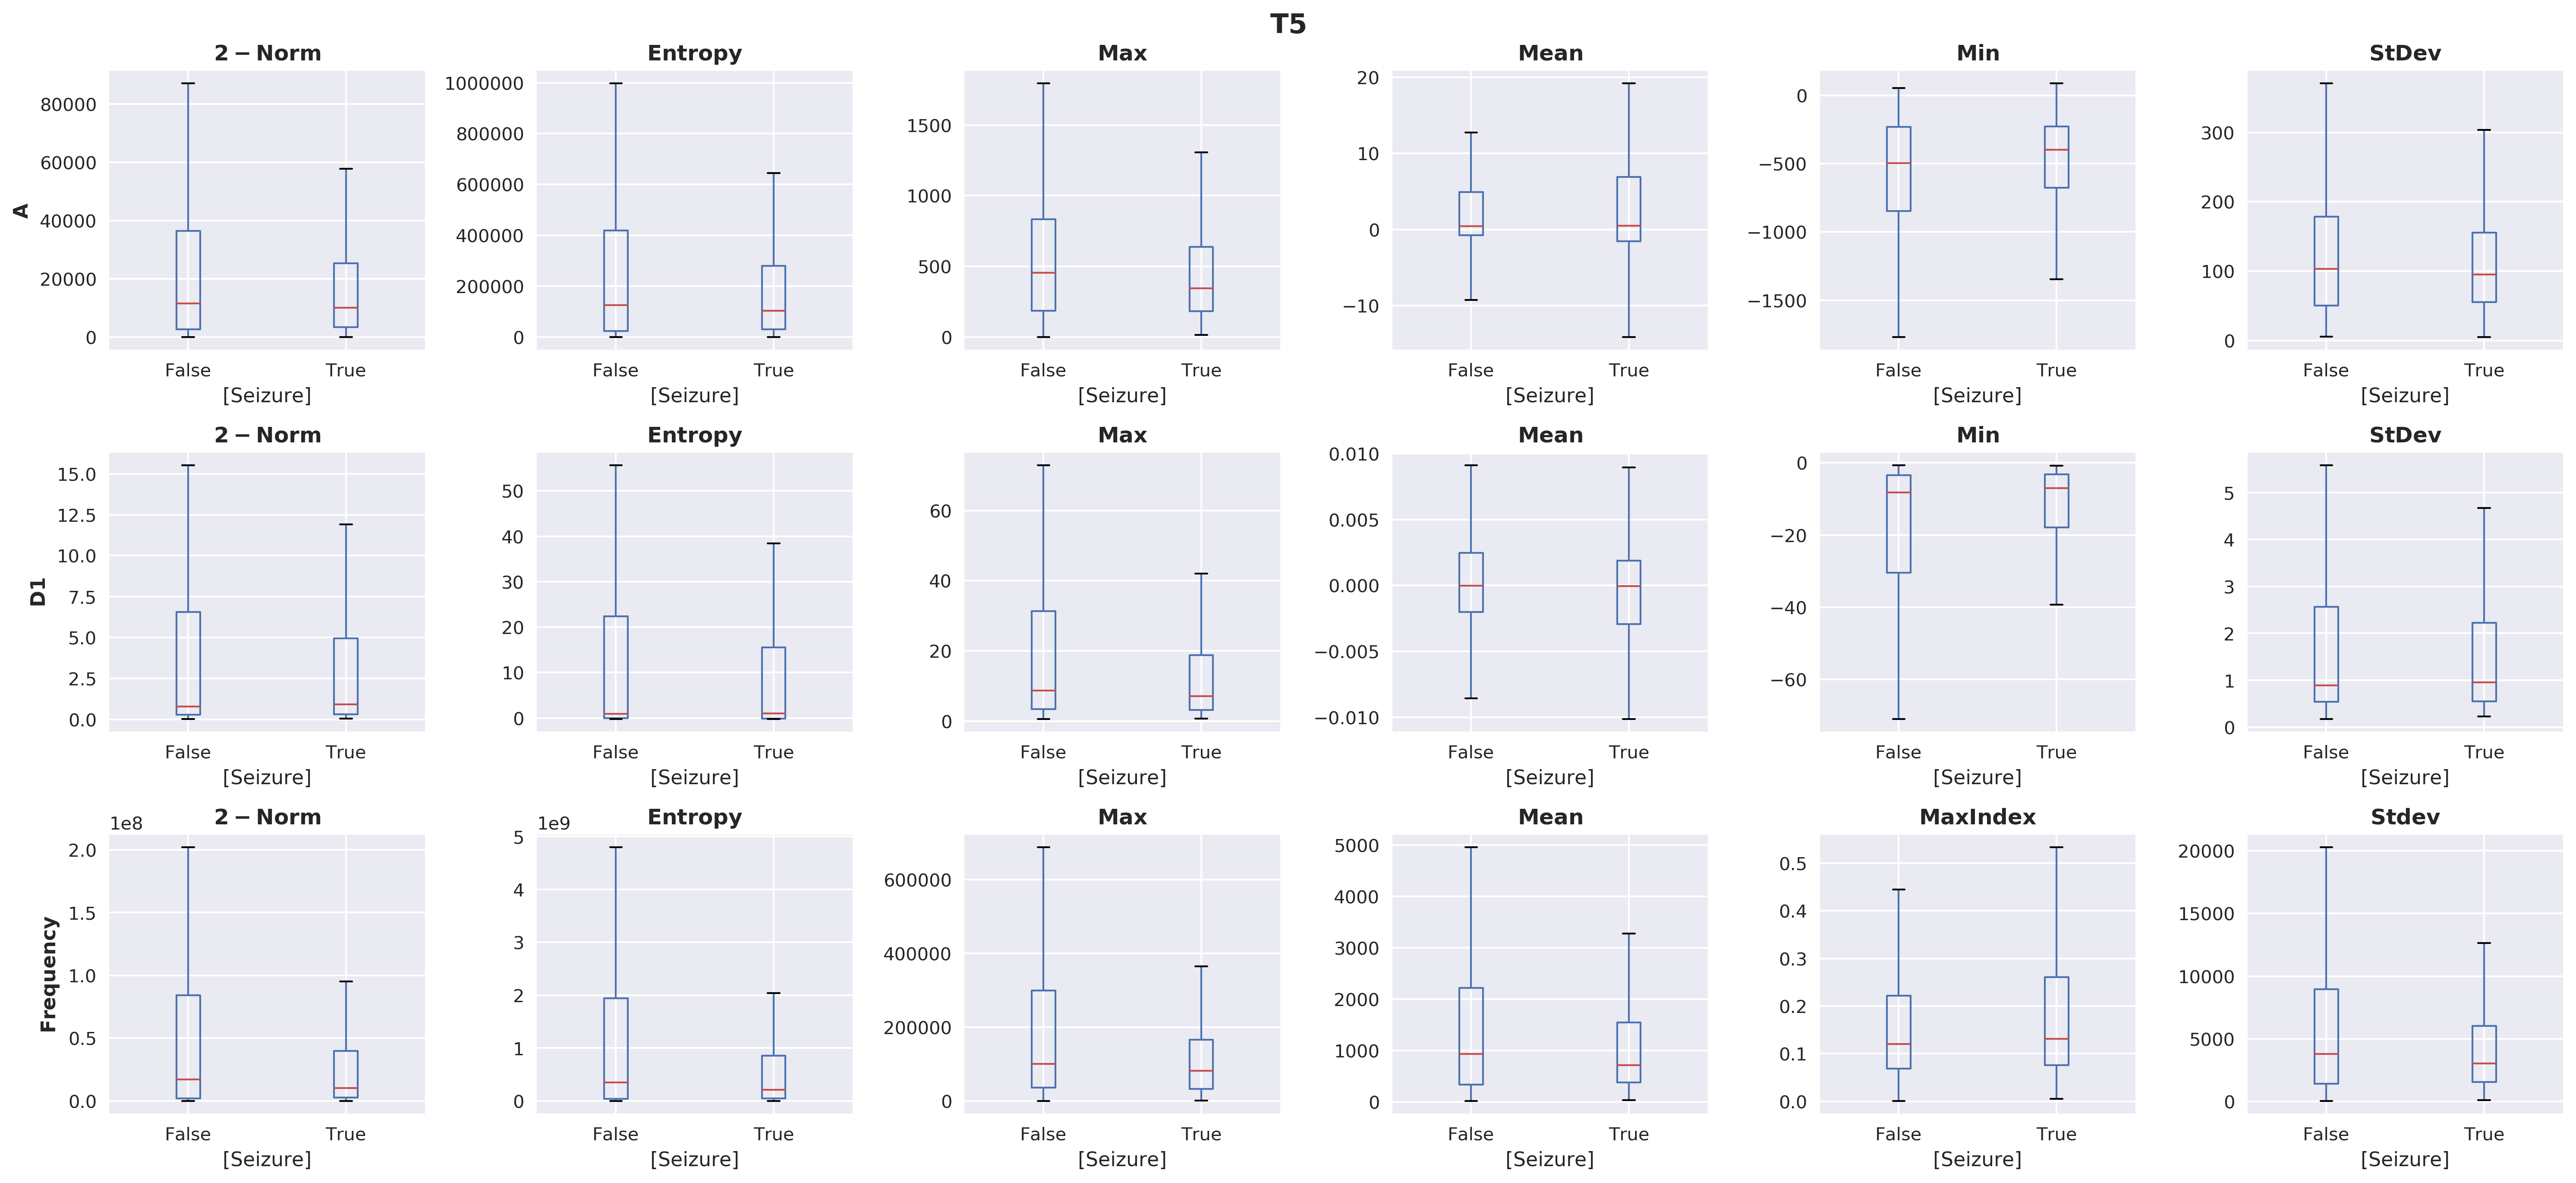

In [33]:
# df = read_data("data-final/eeg.pkl")
# T5_cols = [col for col in df if (col.endswith("T5") and col.startswith(("A", "Freq", "D1"))) or col == "Seizure"]
# plot_features(T5_cols, df, "T5")